In [1]:
from src.utils import SimpleTokenizer

In [2]:
corpus = [
    "The curious cat wandered through the quiet library.",
    "Bright stars shimmered above the calm desert night.",
    "She brewed a fresh cup of coffee before sunrise.",
    "The engineer carefully tuned the ancient machine.",
    "Waves crashed loudly against the rocky shoreline.",
    "He scribbled a poem on the back of a receipt.",
    "They planted herbs in the small balcony garden.",
    "A sudden storm forced the hikers to turn back.",
    "The orchestra rehearsed the finale with precision.",
    "She solved the puzzle after hours of determination."
]

In [4]:
tokenizer = SimpleTokenizer()
print(tokenizer.vocab)
print(tokenizer.encode(corpus[0]))

{'<PAD>': 0, '<UNK>': 1}
[1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
tokenizer.build_vocab(corpus)

In [7]:
print(tokenizer.vocab)
print(tokenizer.encode(corpus[0]))

{'<PAD>': 0, '<UNK>': 1, 'the': 2, 'curious': 3, 'cat': 4, 'wandered': 5, 'through': 6, 'quiet': 7, 'library': 8, 'bright': 9, 'stars': 10, 'shimmered': 11, 'above': 12, 'calm': 13, 'desert': 14, 'night': 15, 'she': 16, 'brewed': 17, 'a': 18, 'fresh': 19, 'cup': 20, 'of': 21, 'coffee': 22, 'before': 23, 'sunrise': 24, 'engineer': 25, 'carefully': 26, 'tuned': 27, 'ancient': 28, 'machine': 29, 'waves': 30, 'crashed': 31, 'loudly': 32, 'against': 33, 'rocky': 34, 'shoreline': 35, 'he': 36, 'scribbled': 37, 'poem': 38, 'on': 39, 'back': 40, 'receipt': 41, 'they': 42, 'planted': 43, 'herbs': 44, 'in': 45, 'small': 46, 'balcony': 47, 'garden': 48, 'sudden': 49, 'storm': 50, 'forced': 51, 'hikers': 52, 'to': 53, 'turn': 54, 'orchestra': 55, 'rehearsed': 56, 'finale': 57, 'with': 58, 'precision': 59, 'solved': 60, 'puzzle': 61, 'after': 62, 'hours': 63, 'determination': 64}
[2, 3, 4, 5, 6, 2, 7, 8]


In [8]:
print(tokenizer(corpus[0], max_len = 20))

[2, 3, 4, 5, 6, 2, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
tokens = ["The", "cat", "sat", "on", "the", "mat"]

token_embeddings = torch.tensor([
    [1.0, 0.0, 0.0], # The
    [1.0, 1.0, 0.0], # cat
    [0.5, 1.0, 0.5], # sat
    [0.0, 1.0, 1.0], # on
    [1.0, 0.0, 0.0], # the
    [1.0, 0.5, 1.0]  # mat 
])

seq_len = token_embeddings.shape[0]
emb_dim = token_embeddings.shape[1]
print(f"Sequence Length: {seq_len}, Embedding Dimension: {emb_dim}")

Sequence Length: 6, Embedding Dimension: 3


In [13]:
class SelfAttention(nn.Module):
    def __init__(self,emb_dim, dropout=0.1):
        super().__init__()

        self.emb_dim = emb_dim

        self.linear_q = nn.Linear(emb_dim, emb_dim)
        self.linear_k = nn.Linear(emb_dim, emb_dim) 
        self.linear_v = nn.Linear(emb_dim, emb_dim)

        self.scale = self.emb_dim ** 0.5
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        Q = self.linear_q(x) 
        K = self.linear_k(x) 
        V = self.linear_v(x) 

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale # torch.bmm(Q, K.transpose(-2, -1)) / self.scale

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, V)

        return context, attn_weights
        

In [14]:
batch_size = 8
seq_len = 100
emb_dim = 128

sample_token_embedding = torch.rand(batch_size, seq_len, emb_dim)

In [15]:
sattention = SelfAttention(emb_dim, dropout=0.1)
context, attn_weights = sattention(sample_token_embedding)

In [16]:
print("Context shape:", context.shape)        # Expected: (batch_size, seq_len, emb_dim)
print("Attention Weights shape:", attn_weights.shape)  # Expected: (batch_size, seq_len, seq_len)

Context shape: torch.Size([8, 100, 128])
Attention Weights shape: torch.Size([8, 100, 100])


In [38]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout = 0.1):
        super().__init__()
        assert emb_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        self.linear_q = nn.Linear(emb_dim, emb_dim)
        self.linear_k = nn.Linear(emb_dim, emb_dim)
        self.linear_v = nn.Linear(emb_dim, emb_dim)

        self.scale = self.head_dim ** 0.5
        self.dropout = nn.Dropout(dropout)
        self.linear_out = nn.Linear(emb_dim, emb_dim)

    def forward(self, x, mask = None):
        batch_size, seq_len, _ = x.size()

        Q = self.linear_q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2) # (bath_size, num_heads, seq_len, head_dim)
        K = self.linear_k(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.linear_v(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale # (batch_size, num_heads, seq_len, seq_len)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, V) # context vector per head

        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.emb_dim) # concatenate heads: (batch_size, seq_len, emb_dim)

        output = self.linear_out(context) # final linear transformation

        return output, attn_weights

In [39]:
batch_size = 32
seq_len = 100
emb_dim = 256
num_heads = 8

sample_token_embedding = torch.rand(batch_size, seq_len, emb_dim)

In [41]:
mhattention = MultiHeadAttention(emb_dim = emb_dim, num_heads=8, dropout=0.1)
output, attn_weights = mhattention(sample_token_embedding)

In [42]:
print("Output shape:", output.shape)        # Expected: (batch_size, seq_len, emb_dim)
print("Attention Weights shape:", attn_weights.shape)  # Expected: (batch_size, num_heads, seq_len, seq_len)
print("Scores shape:", scores.shape)  # Expected: (batch_size, num_heads, seq_len, seq_len)

Output shape: torch.Size([32, 100, 256])
Attention Weights shape: torch.Size([32, 8, 100, 100])
Scores shape: torch.Size([32, 8, 100, 32])


In [97]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sentences = [
    "Hello World",
    "This is a longer sentence"
]

tokens = tokenizer(
    sentences,
    padding = "max_length",
    max_length = 10,
    return_tensors = "pt")

In [98]:
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

In [99]:
print("input_ids:", input_ids)
print("attention_mask:", attention_mask)

input_ids: tensor([[ 101, 7592, 2088,  102,    0,    0,    0,    0,    0,    0],
        [ 101, 2023, 2003, 1037, 2936, 6251,  102,    0,    0,    0]])
attention_mask: tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])


In [100]:
print(f"first sentence tokens: {tokenizer.convert_ids_to_tokens(input_ids[0].tolist())}")
print(f"second sentence tokens: {tokenizer.convert_ids_to_tokens(input_ids[1].tolist())}")

first sentence tokens: ['[CLS]', 'hello', 'world', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
second sentence tokens: ['[CLS]', 'this', 'is', 'a', 'longer', 'sentence', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [101]:
emb_dim = 256
num_heads = 8
seq_len = 10
batch_size = 2

mha = MultiHeadAttention(emb_dim=emb_dim, num_heads=num_heads)

x = torch.rand(batch_size, seq_len, emb_dim)

context, attn_weights = mha(x)
print("Context shape:", context.shape)        # Expected: (batch_size, seq_len, emb_dim
print("Attention Weights shape:", attn_weights.shape)  # Expected: (batch_size, num_heads, seq_len, seq_len)

Context shape: torch.Size([2, 10, 256])
Attention Weights shape: torch.Size([2, 8, 10, 10])


In [102]:
print(f"attention weights for first head of first sample without mask:\n{attn_weights[0,0, :, :]}")

attention weights for first head of first sample without mask:
tensor([[0.1092, 0.1140, 0.1095, 0.1087, 0.1136, 0.1136, 0.1085, 0.1045, 0.1122,
         0.1172],
        [0.1058, 0.1115, 0.1109, 0.1159, 0.1110, 0.1104, 0.1172, 0.1056, 0.1071,
         0.1156],
        [0.1055, 0.1069, 0.1123, 0.1085, 0.1129, 0.0000, 0.1139, 0.1106, 0.1118,
         0.1190],
        [0.0994, 0.1165, 0.1083, 0.0000, 0.1143, 0.1109, 0.1058, 0.1068, 0.1185,
         0.1230],
        [0.0000, 0.1051, 0.1071, 0.1073, 0.0000, 0.1130, 0.1074, 0.1102, 0.1169,
         0.1231],
        [0.1085, 0.1050, 0.1110, 0.1091, 0.1114, 0.1106, 0.1107, 0.1092, 0.1172,
         0.1185],
        [0.1129, 0.1072, 0.1096, 0.1085, 0.1100, 0.0000, 0.1057, 0.1112, 0.1144,
         0.0000],
        [0.1083, 0.1049, 0.1092, 0.1048, 0.1162, 0.0000, 0.1094, 0.1115, 0.1132,
         0.1199],
        [0.1075, 0.1106, 0.1122, 0.1085, 0.1122, 0.1117, 0.1062, 0.1072, 0.1151,
         0.1200],
        [0.1091, 0.1119, 0.1094, 0.1099, 0.000

In [103]:
context, attn_weights = mha(x, mask=attention_mask.unsqueeze(1).unsqueeze(2))

In [107]:
print(f"attention weights for first head of first sample:\n{attn_weights[0,0, :, :]}")

attention weights for first head of first sample:
tensor([[0.2748, 0.2870, 0.2757, 0.2736, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2647, 0.2790, 0.2775, 0.2900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2707, 0.2741, 0.2880, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2559, 0.2997, 0.2786, 0.2769, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2873, 0.2709, 0.2761, 0.2767, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2780, 0.2690, 0.2845, 0.2796, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2862, 0.2718, 0.2779, 0.2752, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2816, 0.0000, 0.2839, 0.2726, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2722, 0.2800, 0.2841, 0.2748, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2753, 0.2823, 0.2761, 0.2774, 0.0000, 0.0000, 0.

In [108]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        dim_indices = torch.arange(0, emb_dim, 2).float()

        div_term = 1.0 / (10000.0 ** (dim_indices / emb_dim)) # torch.exp(dim_indices * (-math.log(10000.0) / emb_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, emb_dim)

        self.register_buffer('pe', pe) # non-trainable buffer

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [119]:
import matplotlib.pyplot as plt

encod_block = PositionalEncoding(emb_dim=emb_dim, max_len=seq_len)
pe_array = encod_block.pe.squeeze().cpu().numpy()

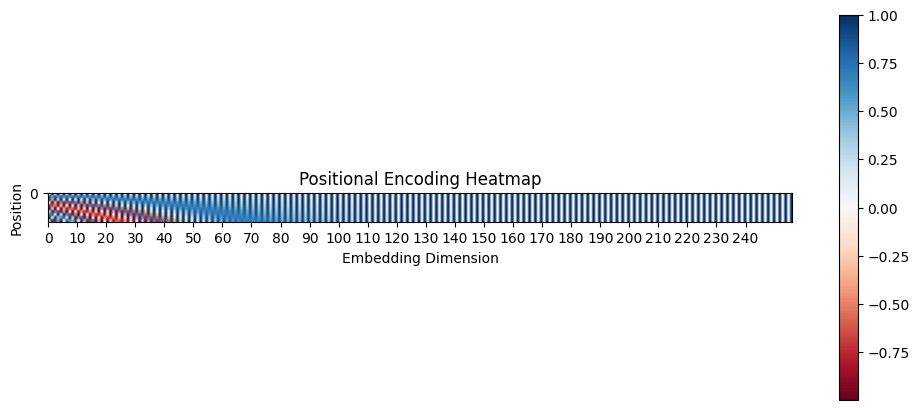

In [124]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 5))
pos = ax.imshow(pe_array, cmap='RdBu', extent=(0, pe_array.shape[1], pe_array.shape[0], 0))
fig.colorbar(pos, ax=ax)
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Position')
ax.set_title('Positional Encoding Heatmap')
ax.set_xticks([i * 10 for i in range(0, pe_array.shape[1] // 10)])
ax.set_yticks([i * 10 for i in range(0, pe_array.shape[0] // 10)])
plt.show()

In [125]:
from transformers import BertTokenizerFast

def get_input_ids(tokenizer, sentences, max_len):
    tokens = tokenizer(
        sentences,
        padding = "max_length",
        max_length = max_len,
        return_tensors = "pt"
    )
    return tokens['input_ids'], tokens['attention_mask']

In [126]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
sentences = ["Hello world!", "This is a longer sentence."]
input_ids, attention_mask = get_input_ids(tokenizer, sentences, max_len=10)
print("Input IDs:", input_ids)
print("Attention Mask:", attention_mask)

Input IDs: tensor([[ 101, 7592, 2088,  999,  102,    0,    0,    0,    0,    0],
        [ 101, 2023, 2003, 1037, 2936, 6251, 1012,  102,    0,    0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [128]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_heads, dropout = 0.1, max_len = 100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, max_len)
        self.pos_dropout = nn.Dropout(dropout)
        self.mha = MultiHeadAttention(hidden_size, num_heads, dropout)

    def forward(self, x, pad_mask = None):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.pos_dropout(x)
        output = self.mha(x, pad_mask)
        return output

In [133]:
from transformer.encoder import MultiHeadAttention

In [137]:
sentences = ["Hello world!", "This is a longer sentence."]

HIDDEN_SIZE = 128
NUM_HEADS = 8
MAX_LEN = 10
BATCH_SIZE = 2

input_ids, pad_mask = get_input_ids(tokenizer, sentences, max_len=MAX_LEN)
encoder = Encoder(vocab_size=tokenizer.vocab_size, hidden_size=HIDDEN_SIZE, num_heads=NUM_HEADS, max_len=MAX_LEN)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
output = encoder(input_ids.to(device), pad_mask.to(device)) # , 
print("Encoder output shape:", output.shape)  # Expected: (BATCH_SIZE, MAX_LEN, HIDDEN_SIZE)

Encoder output shape: torch.Size([2, 10, 128])


In [136]:
pad_mask

tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])